# MNIST mit Caffe2
## Erkennung von Handschriftlichen Ziffern mit LetNet

## Laden der Trainingsdaten
Die 60.000 handschriftlichen Ziffern und die passenden Labels, können vom Webserver von Yann LeCun geladen werden mit wget

In [1]:
!wget -O - http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz > train-images-idx3-ubyte.gz

--2017-11-26 18:07:12--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: 'STDOUT'

-                   100%[===================>]   9.45M  1.26MB/s    in 8.5s    

2017-11-26 18:07:21 (1.12 MB/s) - written to stdout [9912422/9912422]



In [2]:
!wget -O - http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz > train-labels-idx1-ubyte.gz

--2017-11-26 18:07:24--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: 'STDOUT'

-                   100%[===================>]  28.20K  --.-KB/s    in 0.1s    

2017-11-26 18:07:24 (241 KB/s) - written to stdout [28881/28881]



## Laden der Testdaten

In [3]:
!wget -O - http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz > t10k-images-idx3-ubyte.gz

--2017-11-26 18:07:30--  http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1648877 (1.6M) [application/x-gzip]
Saving to: 'STDOUT'

-                   100%[===================>]   1.57M   725KB/s    in 2.2s    

2017-11-26 18:07:32 (725 KB/s) - written to stdout [1648877/1648877]



In [4]:
!wget -O - http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz > t10k-labels-idx1-ubyte.gz

--2017-11-26 18:07:34--  http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4542 (4.4K) [application/x-gzip]
Saving to: 'STDOUT'

-                   100%[===================>]   4.44K  --.-KB/s    in 0.001s  

2017-11-26 18:07:34 (5.48 MB/s) - written to stdout [4542/4542]



## Entpacken der Trainingsdaten

In [5]:
!gunzip train-labels-idx1-ubyte.gz

In [6]:
!gunzip t10k-images-idx3-ubyte.gz

In [7]:
!gunzip t10k-labels-idx1-ubyte.gz

In [8]:
!gunzip train-images-idx3-ubyte.gz

## Erzeugen der LevelDB Datenbanken
Sowohl aus den 10.000 Testdaten als auch aus den 60.000 Trainingsdaten werden Datenbanken im LevelDB-Format erzeugt. Der Zugriff auf die Daten ist effizienter, da alle Daten für den Zugriff als Blob im Speicher liegen.

In [25]:
!/opt/caffe2/build/bin/make_mnist_db \
--channel_first \
--db leveldb \
--image_file /root/notebooks/kapitel6/t10k-images-idx3-ubyte \
--label_file /root/notebooks/kapitel6/t10k-labels-idx1-ubyte \
--output_file /root/notebooks/kapitel6/mnist-test-nchw-leveldb

In [27]:
!/opt/caffe2/build/bin/make_mnist_db \
--channel_first \
--db leveldb \
--image_file /root/notebooks/kapitel6/train-images-idx3-ubyte \
--label_file /root/notebooks/kapitel6/train-labels-idx1-ubyte \
--output_file /root/notebooks/kapitel6/mnist-train-nchw-leveldb

## Import der nötigen Python Module

In [28]:
%matplotlib inline
from matplotlib import pyplot
import numpy as np
import os
import shutil

In [29]:
from caffe2.python import core, cnn, net_drawer, workspace, visualize

In [30]:
base_path = '/root/notebooks/kapitel6/'

In [31]:
image_file_train = os.path.join(base_path,"train-images-idx3-ubyte")
label_file_train = os.path.join(base_path,"train-labels-idx1-ubyte")
image_file_test = os.path.join(base_path,"t10k-images-idx3-ubyte")
label_file_test = os.path.join(base_path,"t10k-labels-idx1-ubyte")

## Module für das Netzwerk
Es empfielt sich, die einzelnen Funktionen des Modelltrainings in entsprechende Python Funktionen zu kapseln. 
Für die Verarbeitung der Daten wird ein Tensor der Form [batch_size, 1, 28, 28] erzeugt.
Die Funktion **CreateInput()** lädt die Daten aus der LevelDB-Datenbank. Die Bilddaten liegen in Grauwerten von 0 - 255 vor. Um diese besser mit Flieskommazahlen berechnen zu können, skalieren wir die Daten auf 0 - 1.

In [32]:
def CreateInput(model, batch_size, db, db_type):
    # load the data
    data_uint8, label = model.TensorProtosDBInput([], ["data_uint8", "label"], batch_size=batch_size, db=db, db_type=db_type)
    # cast the data to float
    data = model.Cast(data_uint8, "data", to=core.DataType.FLOAT)
    # scale data from [0,255] down to [0,1]
    data = model.Scale(data, data, scale=float(1./256))
    # don't need the gradient for the backward pass
    data = model.StopGradient(data, data)
    return data, label

## Modell Erzeugung

Die Funktion **CreateLeNetModel()** erzeugt ein **LeNet** Deep Learning Model. Die Ausgabe übernimmt eine Softmax-Schicht.

In [33]:
def CreateLeNetModel(model, data):
    # Bildgroesse: 28 x 28 -> 24 x 24
    conv1 = model.Conv(data, 'conv1', dim_in=1, dim_out=20, kernel=5)
    # Bildgroesse: 24 x 24 -> 12 x 12
    pool1 = model.MaxPool(conv1, 'pool1', kernel=2, stride=2)
    # Bildgroesse: 12 x 12 -> 8 x 8
    conv2 = model.Conv(pool1, 'conv2', dim_in=20, dim_out=50, kernel=5)
    # Bildgroesse: 8 x 8 -> 4 x 4
    pool2 = model.MaxPool(conv2, 'pool2', kernel=2, stride=2)
    fc3 = model.FC(pool2, 'fc3', dim_in=50 * 4 * 4, dim_out=500)
    fc3 = model.Relu(fc3, fc3)
    pred = model.FC(fc3, 'pred', 500, 10)
    softmax = model.Softmax(pred, 'softmax')
    return softmax

## Accuracy Operator
Um die Modellgüte zu berechnen, wird eine entsprechende Funktion benötigt. 

In [34]:
def CreateAccuracy(model, softmax, label):
    accuracy = model.Accuracy([softmax, label], "accuracy")
    return accuracy

## Training Operator

Die Funktion **CreateTrainingOperators()** erzeugt einen Training Operator für das Model. Die erste Operation innerhalb dieser Funktion ist die Berechnung der Kreuzentropie (eng. cross entropy), welche ein Maß für die Modellgüte darstellt. Verglichen wird hierbei die Eingabe mit den vorhergesagten Ausgabe für den Namen der Ziffer.

Der Operator **AveragedLoss()** nimmt sich die von der Kreuzentropie identifizierten Verlust und liefert deren Durchschnittswert zurück.

Im nächsten Schritt wird mit Hilfe unserer **CreateAccuray()** Funktion bestimmt, wie hoch die Genauigkeit der Modellvorhersage ist.

Der nächste Schnitt stellt den eigentlichen Kern des Modelltrainings dar. Mit Hilfe der Funktion **AddGradientOperators()** wird der Gradientenabstieg berechnet.

Für das Traing wird ein Zähler benötigt, welcher die Trainings-Iterationn aufnummt. Dieser Zähler wird als **ITER** definiert. Als nächstes folgt die Definition der Lernrate mit **LR**. Für die intitalisierung aller Gewichte wird die Funktion **ConstantFill()** für alle Parameter ausgeführt. Die Definierte Konstante **ONE** zeigt an, das dies nur einmal passiert. Beim Update der Gradienten für jeden Parameter hilft uns die nachfolgende Schleife.
Zu guter Letzt speichern wir alle 20 Iterationen die Modell Parameter in eine LevelDB-Datenbank ab. Die kann später als Aufsatzpunkt für die Wiederaufnahme des Modelltrainings genutzt werden.

In [35]:
def CreateTrainingOperators(model, softmax, label):
    """Adds training operators to the model."""
    xent = model.LabelCrossEntropy([softmax, label], 'xent')
    # berechnet den zu erwartenden Verlust
    loss = model.AveragedLoss(xent, "loss")
    # Misst die Genauigkeit der Modellvorhersage
    CreateAccuracy(model, softmax, label)
    # berechnet basierend auf dem durchschnittlichen 
    # Verlust den Gradientenabstieg
    model.AddGradientOperators([loss])
    ITER = model.Iter("iter")
    # Konfiguration der Lernrate
    # ITER Iteration
    # base_lr Richtung der Lernrate (negativ meint absteigend zum Gradienten)
    # policy Art des Abstiegs
    # stepsize Schrittweite
    # gamma 
    LR = model.LearningRate(ITER, "LR", base_lr=-0.1, policy="step", stepsize=1, gamma=0.999)
    ONE = model.param_init_net.ConstantFill([], "ONE", shape=[1], value=1.0)
    # Parameter Update
    for param in model.params:
        param_grad = model.param_to_grad[param]
        model.WeightedSum([param, ONE, param_grad, LR], param)

    model.Checkpoint([ITER] + model.params, [],
        db="mnist_lenet_checkpoint_%05d.leveldb",
        db_type="leveldb", 
        every=20)

## Logging von Accuracy und Loss
Die Entwicklung der Modellgüte soll verfolgt werden können.

In [36]:
def CreateBookkeepingOperators(model):
    model.Print('accuracy', [], to_file=1)
    model.Print('loss', [], to_file=1)
    for param in model.params:
        model.Summarize(param, [], to_file=1)
        model.Summarize(model.param_to_grad[param], [], to_file=1)

## Modelltraining
Innerhalb der nächsten Zeilen, werden die Teile des Modelltrainings zusammengesetzt. Dazu wird die Hilfsfunktion **cnn.CNNModelHelper()** verwendet. Danach wird aus der Trainingsdatenbank die Bilder- und Label-Eingabedaten erzeugt.
Basierend auf den Daten und dem initalen Modell wird dann das LeNet-Modell mit **CreateLeNetModel()** erzeugt, welches die letzte Schicht des Modells zurückliefert. Die beiden letzten Schritte sind dann die Erzeugung des eigentlichen Trainings für das Modell und die Registrierung des Bookkeeping Operators. 

In [37]:
train_model = cnn.CNNModelHelper(order="NCHW", name="mnist_train_model")

In [38]:
data, label = CreateInput(train_model, batch_size=64, db=os.path.join(base_path, 'mnist-train-nchw-leveldb'), db_type='leveldb')

In [39]:
softmax = CreateLeNetModel(train_model, data)

In [40]:
CreateTrainingOperators(train_model, softmax, label)

In [41]:
CreateBookkeepingOperators(train_model)

### Modellvisualisierung
Es gibt zwei Möglichkeiten sich das erzeugte Modell anzusehen. Modelle werden in Caffe im Prototext-Format verwaltet, welches sich einfach als Text augeben lässt. Das gilt sowohl für die Modellparameter

In [42]:
print(str(train_model.param_init_net.Proto()))

name: "mnist_train_model_init"
op {
  output: "dbreader_/root/notebooks/kapitel6/mnist-train-nchw-leveldb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "leveldb"
  }
  arg {
    name: "db"
    s: "/root/notebooks/kapitel6/mnist-train-nchw-leveldb"
  }
}
op {
  output: "conv1_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 20
    ints: 1
    ints: 5
    ints: 5
  }
}
op {
  output: "conv1_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 20
  }
}
op {
  output: "conv2_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 50
    ints: 20
    ints: 5
    ints: 5
  }
}
op {
  output: "conv2_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 50
  }
}
op {
  output: "fc3_w"
  name: ""
  type: "XavierFill"
  arg {
    name: "shape"
    ints: 500
    ints: 800
  }
}
op {
  output: "fc3_b"
  name: ""
  type: "ConstantFill"
  arg {
    name: "shape"
    ints: 500
  }
}
op {
  output: "pred_w"

als auch für das Modell selber

In [43]:
print(str(train_model.net.Proto()))

name: "mnist_train_model"
op {
  input: "dbreader_/root/notebooks/kapitel6/mnist-train-nchw-leveldb"
  output: "data_uint8"
  output: "label"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 64
  }
}
op {
  input: "data_uint8"
  output: "data"
  name: ""
  type: "Cast"
  arg {
    name: "to"
    i: 1
  }
}
op {
  input: "data"
  output: "data"
  name: ""
  type: "Scale"
  arg {
    name: "scale"
    f: 0.00390625
  }
}
op {
  input: "data"
  output: "data"
  name: ""
  type: "StopGradient"
}
op {
  input: "data"
  input: "conv1_w"
  input: "conv1_b"
  output: "conv1"
  name: ""
  type: "Conv"
  arg {
    name: "kernel"
    i: 5
  }
  arg {
    name: "exhaustive_search"
    i: 0
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  engine: "CUDNN"
}
op {
  input: "conv1"
  output: "pool1"
  name: ""
  type: "MaxPool"
  arg {
    name: "kernel"
    i: 2
  }
  arg {
    name: "stride"
    i: 2
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
  arg {
 

Darüber hinaus existiert in Caffe2 die Hilffunktion **net_drawer()**, mit der sich das Modell und seine Operatoren auch graphisch im Jupyter Notebook einbetten lassen.

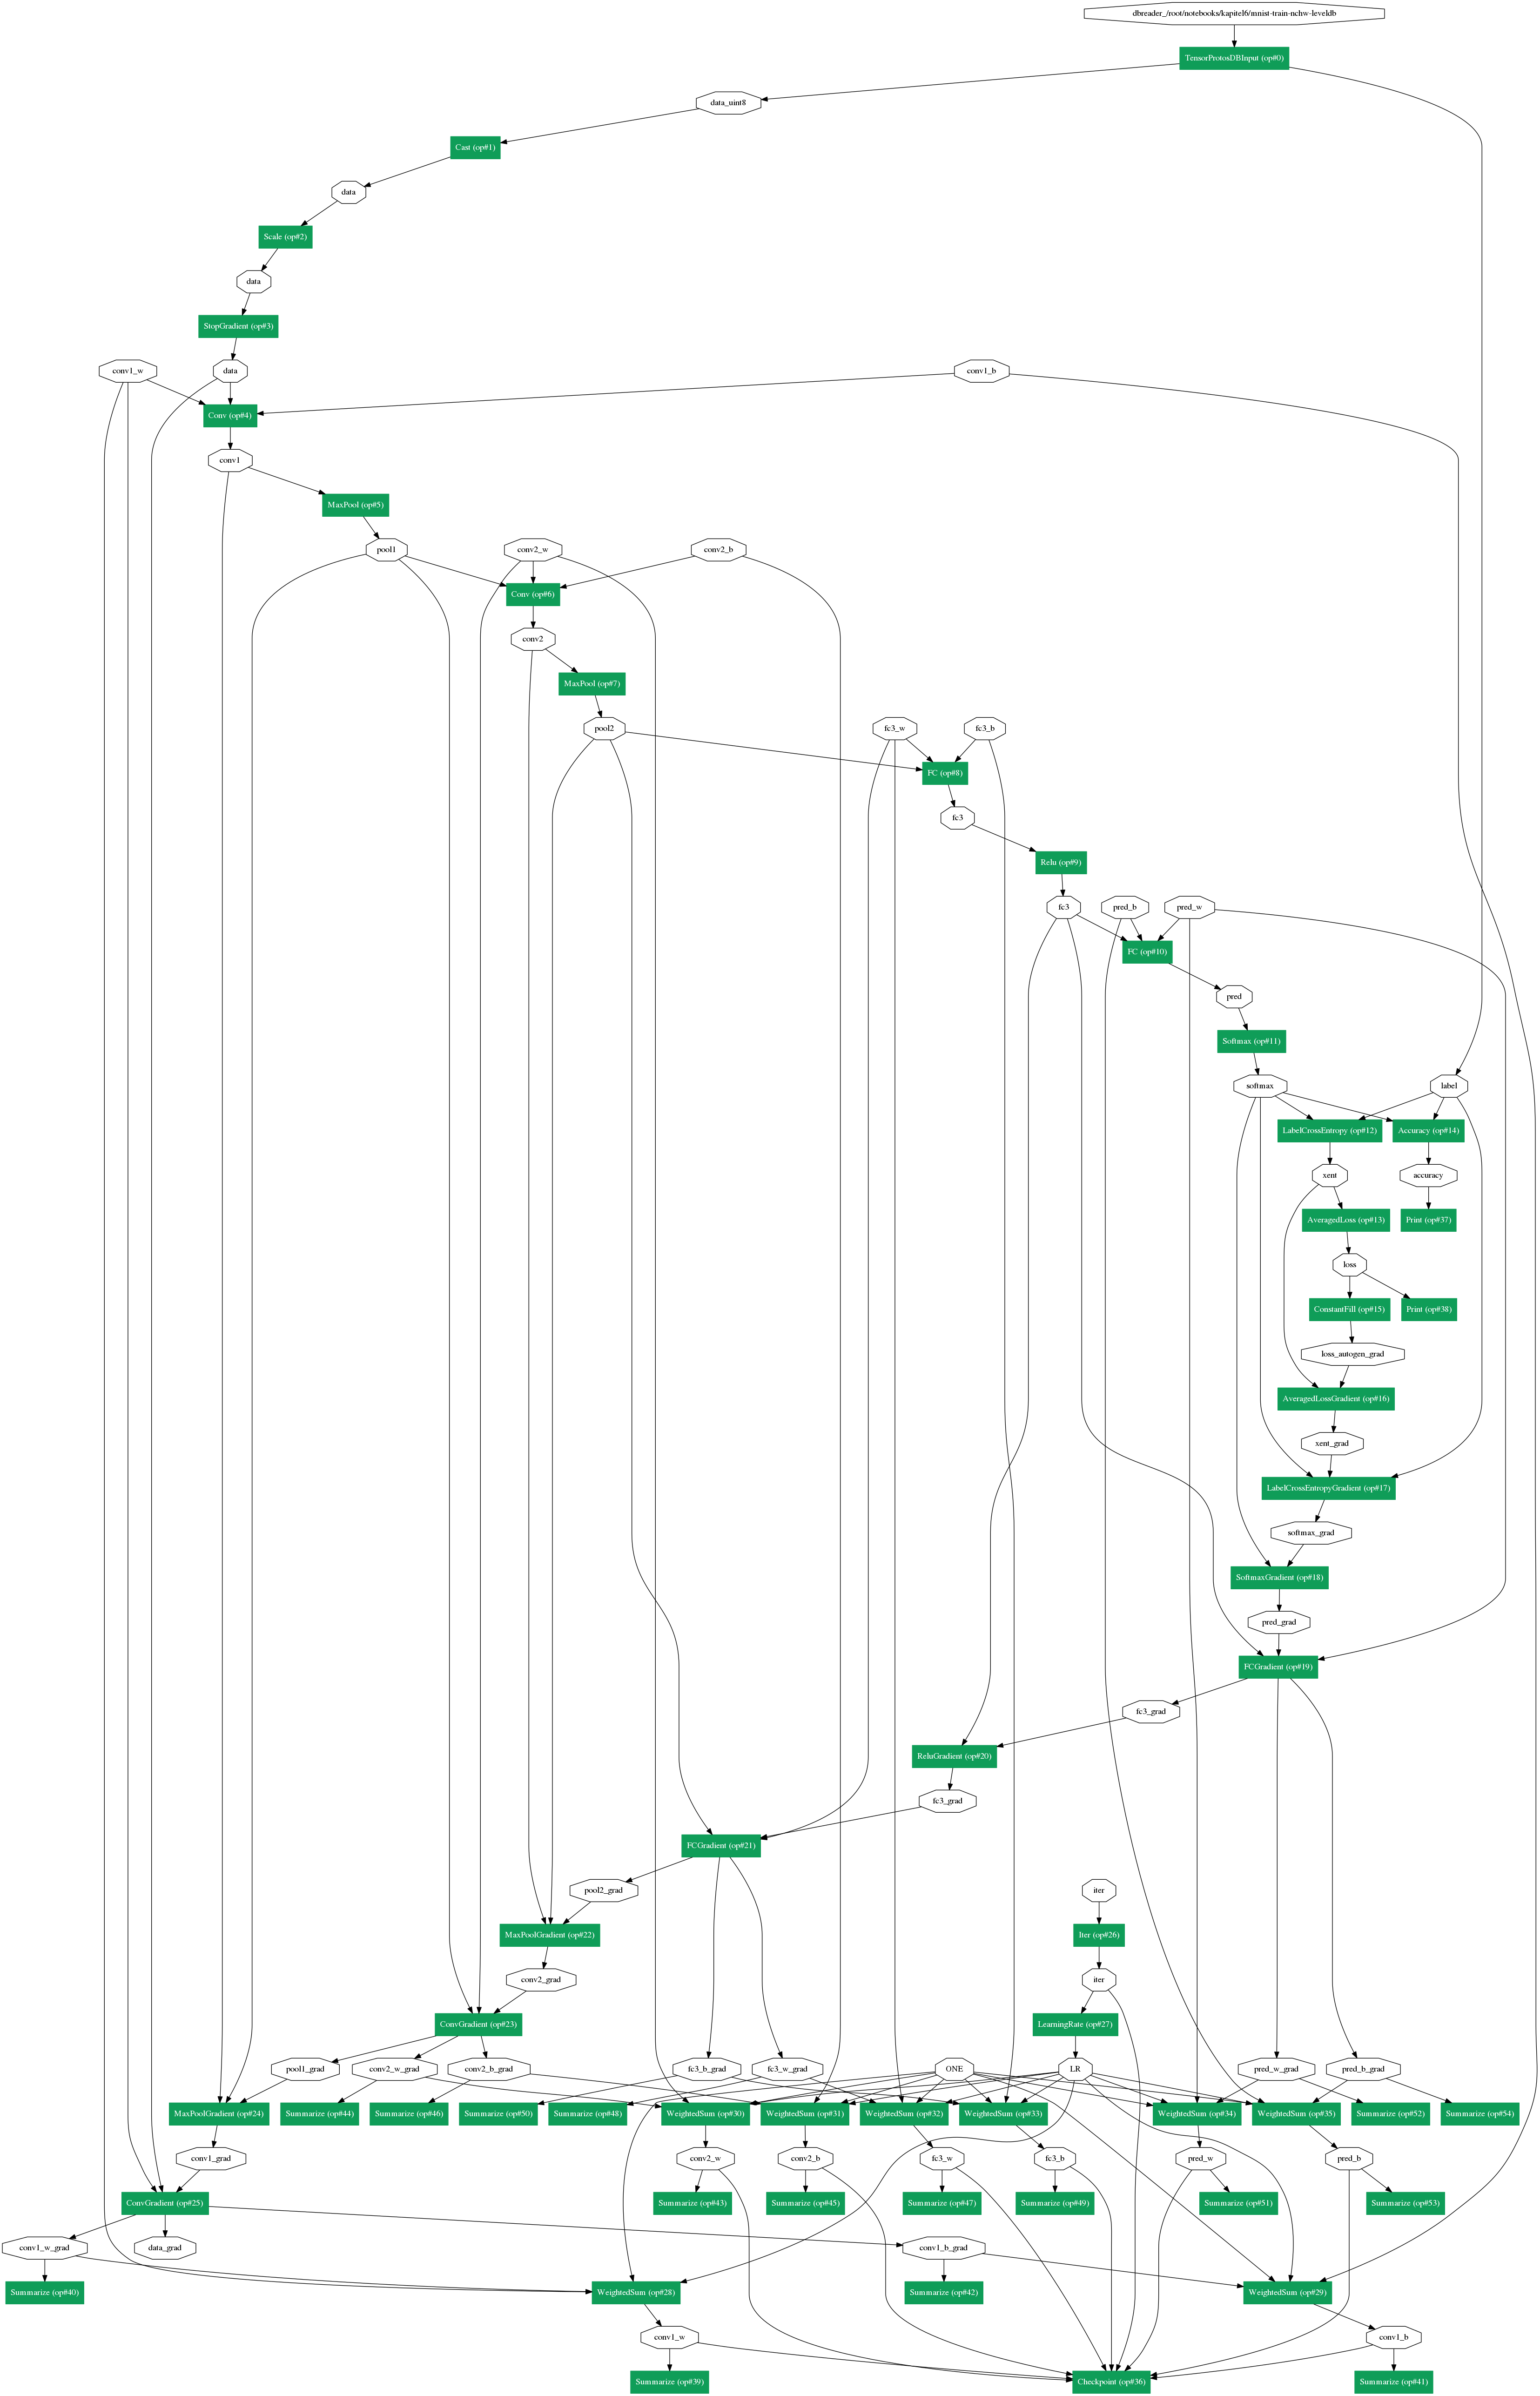

In [44]:
from IPython import display
graph = net_drawer.GetPydotGraph(train_model.net, rankdir="TB")
display.Image(graph.create_png(), width=1200)

## Modelltest
Ebenso wie für die Erstellung des Trainingsmodell können wir mit den gleichen Funktionen auch das entsprechende Modell für den Test unserer Testdaten erzeugen. 

In [45]:
test_model = cnn.CNNModelHelper(
    order="NCHW", 
    name="mnist_test", 
    init_params=False)

data, label = CreateInput(
    test_model, 
    batch_size=100,
    db=os.path.join(base_path, 'mnist-test-nchw-leveldb'),
    db_type='leveldb')

softmax = CreateLeNetModel(test_model, data)
CreateAccuracy(test_model, softmax, label)

In [46]:
print(str(test_model.param_init_net.Proto()))

name: "mnist_test_init"
op {
  output: "dbreader_/root/notebooks/kapitel6/mnist-test-nchw-leveldb"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "leveldb"
  }
  arg {
    name: "db"
    s: "/root/notebooks/kapitel6/mnist-test-nchw-leveldb"
  }
}



In [47]:
print(str(test_model.net.Proto()))

name: "mnist_test"
op {
  input: "dbreader_/root/notebooks/kapitel6/mnist-test-nchw-leveldb"
  output: "data_uint8"
  output: "label"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 100
  }
}
op {
  input: "data_uint8"
  output: "data"
  name: ""
  type: "Cast"
  arg {
    name: "to"
    i: 1
  }
}
op {
  input: "data"
  output: "data"
  name: ""
  type: "Scale"
  arg {
    name: "scale"
    f: 0.00390625
  }
}
op {
  input: "data"
  output: "data"
  name: ""
  type: "StopGradient"
}
op {
  input: "data"
  input: "conv1_w"
  input: "conv1_b"
  output: "conv1"
  name: ""
  type: "Conv"
  arg {
    name: "kernel"
    i: 5
  }
  arg {
    name: "exhaustive_search"
    i: 0
  }
  arg {
    name: "order"
    s: "NCHW"
  }
  engine: "CUDNN"
}
op {
  input: "conv1"
  output: "pool1"
  name: ""
  type: "MaxPool"
  arg {
    name: "kernel"
    i: 2
  }
  arg {
    name: "stride"
    i: 2
  }
  arg {
    name: "cudnn_exhaustive_search"
    i: 0
  }
  arg {
    name

In [48]:
deploy_model = cnn.CNNModelHelper(order="NCHW", name="mnist_deploy_model", init_params=False)
CreateLeNetModel(deploy_model, "data")

BlobReference("softmax")

## Training Prozedur
Das eigentliche Training des Modells wird mit Hilfe eines Caffe2 Workspaces realsiert. Die Workspace-Struktur wird dabei mit dem Trainingsmodell und den initialen Trainigsparametern gestartet. Die Funktion **RunNet()** ...

In [49]:
workspace.RunNetOnce(train_model.param_init_net)

True

In [50]:
workspace.CreateNet(train_model.net, overwrite=True)

True

In [51]:
total_iters = 200000
accuracy = np.zeros(total_iters)
loss = np.zeros(total_iters)

In [ ]:
for i in range(total_iters):
    workspace.RunNet(train_model.net.Proto().name)
    accuracy[i] = workspace.FetchBlob('accuracy')
    loss[i] = workspace.FetchBlob('loss')

## Ergebnisse anzeigen
Das interessanteste Ergegbnis ist die Modellgüte, welche sich mit Hilfe eines einfachen pylots schnell und einfach anzeigen lässt.

In [ ]:
pyplot.plot(loss, 'b')
pyplot.plot(accuracy, 'r')
pyplot.legend(('Loss', 'Accuracy'), loc='upper right')

Darüber hinaus lassen sich auch Teile der Eingabedaten, welche sich in der Dateneingangsschicht befinden, einfach anzeigen lassen mit

In [ ]:
pyplot.figure()
data = workspace.FetchBlob('data')
_ = visualize.NCHW.ShowMultiple(data)
pyplot.figure()

Die Vorhersagegüte für eine bestimmte Ziffer, lässt sich am Softmax ausgeben mit

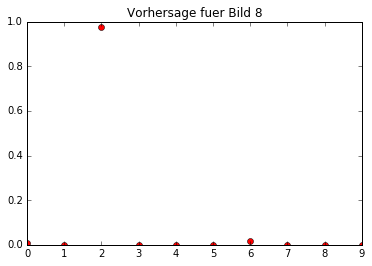

In [99]:
image_number = 9
softmax = workspace.FetchBlob('softmax')
_ = pyplot.plot(softmax[image_number], 'ro')
title = 'Vorhersage fuer Bild %s'%str(image_number-1)
pyplot.title(title)

Die Parameter innerhalb jeder Schicht lassen sich wie folgt ausgeben

In [38]:
print("Nach dem Training sehen die Gewichte der Schicht 'pool1' so aus : {}".format(workspace.FetchBlob("pool1")))

Nach dem Training sehen die Gewichte der Schicht 'pool1' so aus : [[[[ -1.47773847e-01  -1.47773847e-01  -1.47773847e-01 ...,
     -1.47773847e-01  -1.47773847e-01  -1.47773847e-01]
   [ -1.47773847e-01  -1.47773847e-01  -1.47773847e-01 ...,
     -1.47773847e-01  -1.47773847e-01  -1.47773847e-01]
   [ -1.47773847e-01  -1.47773847e-01  -1.47773847e-01 ...,
     -1.47773847e-01  -1.47773847e-01  -1.47773847e-01]
   ..., 
   [ -1.47773847e-01  -1.47773847e-01  -1.47773847e-01 ...,
     -1.51619151e-01  -1.47773847e-01  -1.47773847e-01]
   [ -1.47773847e-01  -1.47773847e-01  -1.47773847e-01 ...,
     -1.47773847e-01  -1.47773847e-01  -1.47773847e-01]
   [ -1.47773847e-01  -1.47773847e-01  -1.47773847e-01 ...,
     -1.47773847e-01  -1.47773847e-01  -1.47773847e-01]]

  [[ -8.57722852e-03  -8.57722852e-03  -8.57722852e-03 ...,
     -8.57722852e-03  -8.57722852e-03  -8.57722852e-03]
   [ -8.57722852e-03  -8.57722852e-03  -8.57722852e-03 ...,
     -8.57722852e-03  -8.57722852e-03  -8.57722852e

In [100]:
print("Nach dem Training sehen die Gewichte der Schicht 'softmax' so aus : {}".format(workspace.FetchBlob("softmax")))

Nach dem Training sehen die Gewichte der Schicht 'softmax' so aus : [[  4.74173634e-04   3.04203044e-04   3.25698871e-04   1.83441304e-02
    1.12282122e-02   9.35296834e-01   4.91697062e-03   1.01940450e-03
    1.73172876e-02   1.07731437e-02]
 [  5.04444415e-07   1.60391835e-07   9.62079866e-06   3.65541171e-04
    3.29862132e-07   1.00521529e-05   4.38383774e-09   9.99242187e-01
    2.13138287e-06   3.69412795e-04]
 [  3.20120889e-05   7.40034011e-05   4.89242939e-06   2.84042442e-04
    7.69999623e-02   2.40260866e-04   1.29633133e-06   3.54098156e-04
    9.00948595e-04   9.21108484e-01]
 [  1.06299121e-04   3.64055777e-05   1.78909290e-03   4.79665148e-04
    1.67473480e-02   1.58002805e-02   5.20622671e-05   9.13983677e-03
    4.89603356e-03   9.50952947e-01]
 [  1.01028872e-05   1.31789234e-03   9.93617535e-01   3.97348078e-03
    1.03299658e-06   1.54714344e-05   1.59983267e-06   3.87423817e-04
    6.57513097e-04   1.78535938e-05]
 [  9.65594471e-01   7.72448584e-06   2.5967167

Auch die Ergebnisse einzelner Schichten lassen sich visualisieren

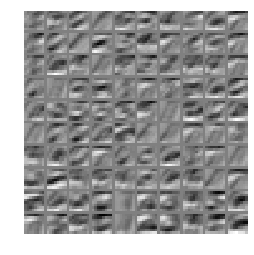

In [104]:
pyplot.figure()
conv = workspace.FetchBlob('conv2')
shape = list(conv.shape)
shape[1] = 1
conv = conv[:,15,:,:].reshape(shape)
_ = visualize.NCHW.ShowMultiple(conv)

Basierend auf dem Testmodell lässt sich auch die Modellgüte für die 10.000 Bilder, die nicht im Modelltraining beteiligt waren, berechnen mit

In [105]:
workspace.RunNetOnce(test_model.param_init_net)
workspace.CreateNet(test_model.net, overwrite=True)
test_accuracy = np.zeros(500)
for i in range(500):
    workspace.RunNet(test_model.net.Proto().name)
    test_accuracy[i] = workspace.FetchBlob('accuracy')

Die Ausgabe der Modellgüte zeigt folgende Ausgabe

Durchschnittliche Testgenauigkeit : 0.952700


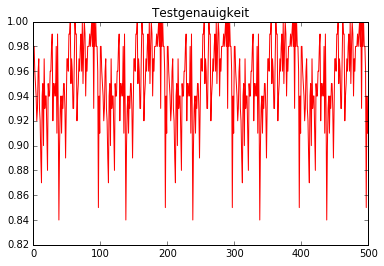

In [106]:
pyplot.plot(test_accuracy, 'r')
pyplot.title('Testgenauigkeit')
print('Durchschnittliche Testgenauigkeit : %f' % test_accuracy.mean())